In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp
from collocation.bvp import OrthogonalCollocation

In [2]:
# print(plt.style.available)
plt.style.use('fivethirtyeight')

# Example 1
Solve a second order differential equation with solve_bvp.

$ y'' + 9y = cos(t),~y(π) = −5/3,~y'(0) = 5 $

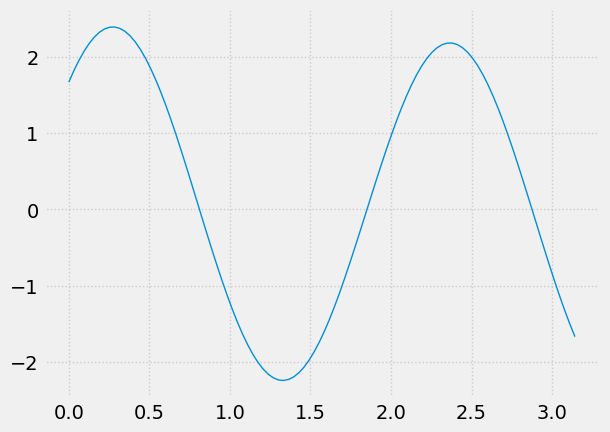

In [3]:
def ode(x, y):
    
    return np.vstack((y[1], -9*y[0] + np.cos(x)))

def bc(ya, yb):
    
    left = ya[0:2]
    right = yb[0:2]
    
    return np.array([left[1] - 5, right[0] + 5/3, ])

x = np.linspace(0, np.pi, 100)
y = np.zeros((2, x.size))

sol = solve_bvp(ode, bc, x, y)

y, yp = sol.y

plt.plot(sol.x, y, lw = 1)
plt.grid(linestyle = 'dotted')

# Example 2
Solve a forth order differential equation with solve_bvp.

$ y''''(x) = x,~y(0) = 0,~y''(0) = 0,~y(1) = 0,~y''(1) = 0$

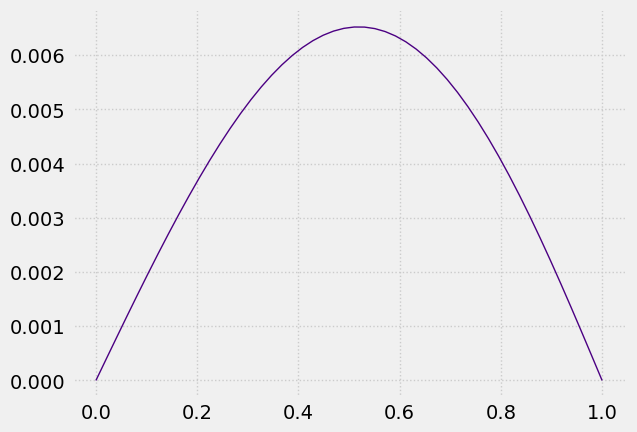

In [4]:
def fun(x, y):
    
    return np.vstack((y[1], y[2], y[3], x))

# ya: lower boundary which is 0 and yb: maximum boundary which is 1 for this example
def bc(ya, yb):
    
    return np.array([ya[0] - 0, ya[2] - 0, yb[0] - 0, yb[2] - 0])

x = np.linspace(0, 1, 50)
y = np.zeros((4, x.size)) # because wigh have 4 arrays from to return from bc function

sol = solve_bvp(fun, bc, x, y)

y, yp, ypp, yppp = sol.y

plt.plot(sol.x, y, color = 'indigo', lw = 1)
plt.grid(linestyle = 'dotted')

# Example 4
Solve a second order differential equation with a boundary condition residual with solve_bvp.

$y'' + k^2y = 0,~y(0) = y(1) = 0 $

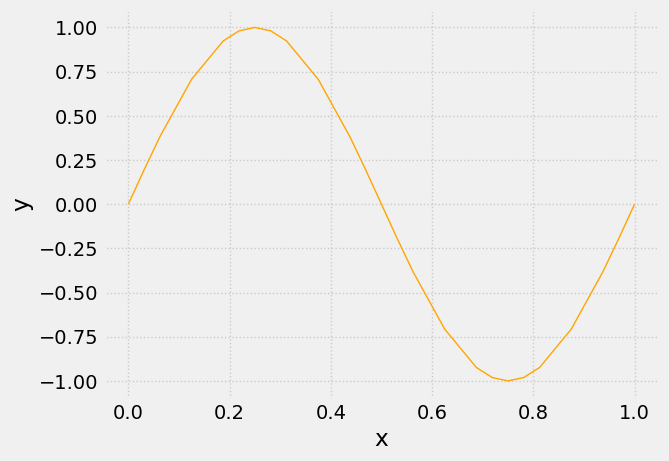

In [5]:
def fun(x, Y, k):
    
    y, yp = Y
    ypp = -y*k**2
    
    return np.array([yp, ypp])

# ya stands for y(0) and yb stands for y(1)
def bc(ya, yb, p):
    # boundary condition residual
    k = p[0]

    return np.array([ya[0] - 0, ya[1] - k, yb[0] - 0]) # y'(0) = k

x = np.linspace(0, 1, 5)
y = np.zeros((2, x.size))
y[0, 1] = 1
y[0, 3] = -1

# solve bvp
sol = solve_bvp(fun, bc, x, y, p=[6])

y, yp = sol.y

plt.plot(sol.x, y, color = 'orange', lw = 1)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(linestyle = 'dotted')

# Example 5

$\frac{d^2 y}{d x^2} + ky + 1 = 0 $

$\frac{d y}{d x} - 1 = 0~at~x=1$

$\frac{d y}{d x} = 0~at~x=0$

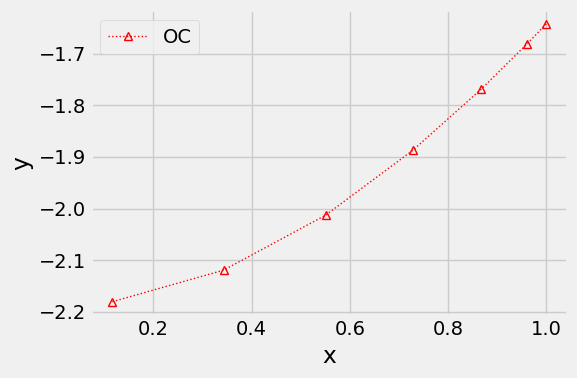

In [6]:
# Internal function
def fun_1(x, y, dy, d2y, k):
    
    return d2y[0] + k * y[0] + 1

# Boundary function
def bc_1(x, y, dy, d2y, k):
    
    return dy[0] - 1

k = 1.

# Number of collocatioin points
n_points = 6

# Create problem
problem_1 = OrthogonalCollocation(fun_1, bc_1, n_points, 1, x0 = 0.0, x1 = 1.0, vectorized=True)

# Initial estimation
y01 = np.zeros([1, n_points + 1])

# Collocation using scipy.optimize.root in backend
problem_1.collocate(y01, args = k, method = "hybr", tol = 1e-6)

# Create a plot
fig, ax = plt.subplots(figsize = [6, 4])

x = np.linspace(0, 1, 50)
ax.plot(problem_1.x, problem_1.y[0], "^r:", mfc = 'none', label="OC", lw = 1)

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.legend()
fig.tight_layout()

***In numerical analysis, the shooting method is a method for solving a boundary value problem by reducing it to an initial value problem.***

# Example 6

Sove a system of differential equations using solve_ivp

$\frac{d^2 x}{d t^2} = (4+x)\frac{d y}{d t} - 5x + 9.81cos(y)$

$\frac{d^2 y}{d t^2} = \frac {-9.81sin(y) - 2\frac{d x}{d t}\frac{d y}{d t}}{0.4 + x}$

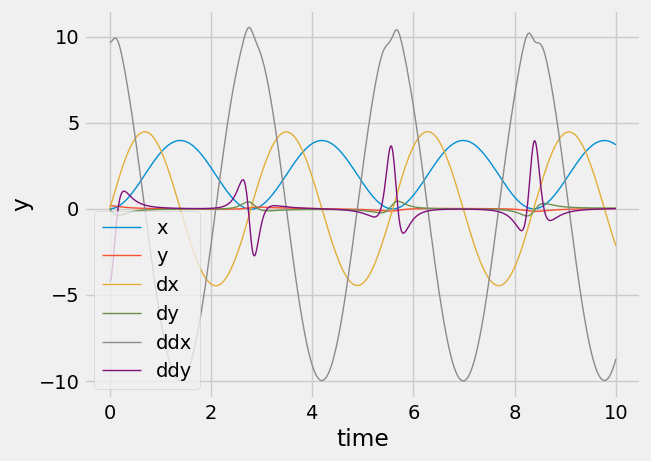

In [7]:
def deriv(t, Y):
    
    x, y, dx, dy = Y
    
    ddx = (4 + x)*(dy)**2 - 5*x + 9.81*np.cos(y)
    
    ddy = (-9.81*np.sin(y)-2*(dx)*(dy))/(0.4 + x)
    
    return np.array([dx, dy, ddx, ddy])

# initial values
init = np.array([0.0, np.pi/18, 0.0, 0.0]) 

t = np.linspace(0.0, 10.0, 1000)

sol = solve_ivp(deriv, [t[0], t[-1]], init, t_eval = t)

# solution of the system
x, y, dx, dy = sol.y

ddx = (4 + x)*(dy)**2 - 5*x + 9.81*np.cos(y)
    
ddy = (-9.81*np.sin(y)-2*(dx)*(dy))/(0.4 + x)

# plots
plt.xlabel("time")
plt.ylabel("y")
plt.plot(sol.t, sol.y[0,:], label = 'x', lw = 1)
plt.plot(sol.t, sol.y[1,:], label = 'y', lw = 1)
plt.plot(sol.t, sol.y[2,:], label = 'dx', lw = 1)
plt.plot(sol.t, sol.y[3,:], label = 'dy', lw = 1)
plt.plot(sol.t, ddx, label = 'ddx', lw = 1)
plt.plot(sol.t, ddy, label = 'ddy', lw = 1)

plt.legend()

# Example 7: System of equations (comparing scipy and OC)

$\frac{d^2 y_1}{dx^2} + k_1 y_2 + 1 = 0$

$\frac{d^2 y_2}{dx^2} + k_2 log(1 + y_1) = 0$

$\frac{dy_1}{dx} = 0$ at $x = 0$

$\frac{dy_2}{dx} = 0$ at $x = 0$

$y_1 = 0$ at $x = 1$

$y_2 - 1 = 0$ at $x = 1$


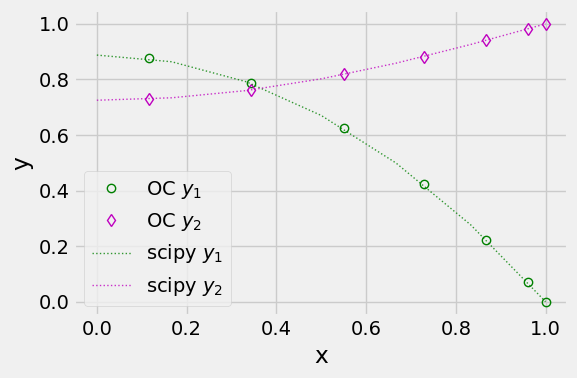

In [8]:
# using scipy
def odes(x, y):

    return np.vstack((y[2], y[3], -k1*y[1] - 1, -k2*np.log(1 + y[0])))

def bc(ya, yb):

    # append can only take 2 arguments so the second one should be included within a list
    return np.append(ya[2:], [yb[0], yb[1] - 1])

k1 = 1.0
k2 = -1.0

# initial values
x = np.linspace(0, 1, 7)
y = np.zeros((4, x.size))

# solve bvp
sol = solve_bvp(odes, bc, x, y)


# using orthogonical collocation
# Internal function
def oc_fun(x, y, dy, d2y, k1, k2):
    
    return np.array([
                     d2y[0] + k1 * y[1] + 1, 
                     d2y[1] + k2 * np.log(1 + y[0])
                    ])

# Boundary function - only the right side
def oc_bc(x, y, dy, d2y, k1, k2):
    
    return np.array([y[0], y[1] - 1])

k1 = 1.0
k2 = -1.0

# Number of collocatioin points
n_points = 6
problem_2 = OrthogonalCollocation(oc_fun, oc_bc, n_points, 1, x0 = 0.0, x1 = 1.0)
y0 = np.zeros([2, n_points + 1])
problem_2.collocate(y0, args = (k1, k2), method = "hybr", tol = 1e-6)

# plots
fig, ax = plt.subplots(figsize = [6, 4])

x = np.linspace(0, 1, 50)

ax.plot(problem_2.x, problem_2.y[0], color = "g", marker = "o", mfc = 'none', label="OC $y_1$", linestyle = " ")
ax.plot(problem_2.x, problem_2.y[1], color = "m", marker = "d", mfc = 'none', label="OC $y_2$", linestyle = " ")

ax.plot(sol.x, sol.y[0], color = "g", alpha = 0.8, linestyle = ":", label = "scipy $y_1$", lw = 1)
ax.plot(sol.x, sol.y[1], color = "m", alpha = 0.8, linestyle = ":", label = "scipy $y_2$", lw = 1)

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.legend()
fig.tight_layout()